In [1]:
#Import packages
import os #Allows us to get operating system information in python.
#In artemis video, he did not import os package

#Data Handling
import pandas as pd, numpy as np

#Time
import time

#Plotting
import matplotlib.pyplot as plt, seaborn as sns, scipy.stats, pylab

#Saving data
import pickle

#train and test split
from sklearn.model_selection import train_test_split

#Scalers
from sklearn import preprocessing

#TomekLinks and RandomUnderSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

#Hyperparameter optimization
import optuna

#Visualize ML algorithm features
import shap

#Metrics
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score, roc_auc_score, ConfusionMatrixDisplay

#To save tables as images
import dataframe_image as dfi

#General Management
import gc as gc
gc.enable()
from joblib import dump, load
from warnings import filterwarnings

#Notebook configurations
filterwarnings('ignore')

In [2]:
#FINAL MODELS 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
#IMPORT ORIGINAL DATA
f = open('CCF_ProcessedData.pckl','rb')
pickle_list = pickle.load(f)
f.close()

tomek_modeling_data = pickle_list[0]
y = pickle_list[1]
rus_tomek_modeling_data = pickle_list[2]
y2 = pickle_list[3]
test = pickle_list[4] #The most important variable we are importing in this script

In [4]:
#IMPORT THE DATA THAT WE WILL USE TO TRAIN FINAL MODELS BEFORE TESTING ON TEST DATA
def get_tomek_data():
    f = open('tomek_data.pckl','rb')
    data = pickle.load(f)
    f.close()
    return data

tomek_data = get_tomek_data() #import tomek data that's been split up into train and dev sets
tomek_X_train = tomek_data[0]
tomek_X_dev = tomek_data[1]
tomek_y_train = tomek_data[2]
tomek_y_dev = tomek_data[3]


def get_rus_data():
    f = open('rus_data.pckl','rb')
    data = pickle.load(f)
    f.close()
    return data

rus_data = get_rus_data() #import tomek+rus data that's been split up into train and dev sets
rus_X_train = rus_data[0]
rus_X_dev = rus_data[1]
rus_y_train = rus_data[2]
rus_y_dev = rus_data[3]

### FINAL MODEL FOR TOMEK DATA 
Gaussian Naïve Bayes with varsmoothing = 9.125860889745052 * (10**-9)

In [6]:
#Get the final model ready
vs_final = 9.125860889745052 * (10**-9)
fmodel_tomek = GaussianNB(var_smoothing=vs_final)
fmodel_tomek.fit(tomek_X_train,tomek_y_train)

GaussianNB(var_smoothing=9.125860889745052e-09)

In [7]:
recall_tomek = round(recall_score(tomek_y_dev,fmodel_tomek.predict(tomek_X_dev)),3)
f1_tomek = round(f1_score(y_true=tomek_y_dev, y_pred=fmodel_tomek.predict(tomek_X_dev)),3)
bacc_tomek = round(balanced_accuracy_score(tomek_y_dev, y_pred=fmodel_tomek.predict(tomek_X_dev)),3)

print("Recall of Final Tomek Model: {}".format(recall_tomek))
print("F1 Score of Final Tomek Model: {}".format(f1_tomek))
print('Balanced Accuracy Score of Final Tomek Model: {}'.format(bacc_tomek))


Recall of Final Tomek Model: 0.998
F1 Score of Final Tomek Model: 0.005
Balanced Accuracy Score of Final Tomek Model: 0.73


### FINAL MODEL FOR TOMEK+RUS DATA 
Random Forest Classifier with the following parameters:
 'rfc_num_exp': 3,
 'rfc_num_base': 9.8410100557842,
 'rfc_maxdepth': 5,
 'rfc_ml_exp': 3,
 'rfc_ml_base': 9.56629896082272,
 'rfc_bootstrap': True,
 'rfc_maxsamples': 0.9767807421240824

In [9]:
#FINAL VALUES
rfc_num = 9841
rfc_maxdepth = 5
rfc_minleaf = 9566
rfc_bootstrap = True
rfc_maxsamples = 0.9767807421240824

fmodel_rus = RandomForestClassifier(n_estimators=rfc_num, max_depth=rfc_maxdepth,
                                   min_samples_leaf=rfc_minleaf, bootstrap=rfc_bootstrap,
                                   max_samples=rfc_maxsamples, random_state=10)
fmodel_rus.fit(rus_X_train,rus_y_train)

RandomForestClassifier(max_depth=5, max_samples=0.9767807421240824,
                       min_samples_leaf=9566, n_estimators=9841,
                       random_state=10)

In [10]:
recall_rus = round(recall_score(rus_y_dev,fmodel_rus.predict(rus_X_dev)),3)
f1_rus = round(f1_score(y_true=rus_y_dev, y_pred=fmodel_rus.predict(rus_X_dev)),3)
bacc_rus = round(balanced_accuracy_score(rus_y_dev, y_pred=fmodel_rus.predict(rus_X_dev)),3)

print("Recall of Final Tomek+RUS Model: {}".format(recall_rus))
print("F1 Score of Final Tomek+RUS Model: {}".format(f1_rus))
print('Balanced Accuracy Score of Final Tomek+RUS Model: {}'.format(bacc_rus))

Recall of Final Tomek+RUS Model: 1.0
F1 Score of Final Tomek+RUS Model: 0.667
Balanced Accuracy Score of Final Tomek+RUS Model: 0.5


## SAVE THE FINAL MODELS

In [23]:
pickle_list = [fmodel_tomek,fmodel_rus]
f = open('FinalModels.pckl','wb')
pickle.dump(pickle_list,f)
f.close()

# TEST DATA 

In [11]:
#Grab the column order of the training data for later

#test.head(10)
#test.dtypes
#test.shape

final_col_order = tomek_X_train.columns

### STEP 1 CHANGE THE DATA TYPES + OTHER STUFF

In [12]:
#First, lets do the basics and grab the num columns, cat columns, and labels for the data
test_y = test['isFraud']
test_y = pd.DataFrame(test_y,columns=['isFraud']).astype('int') 
#Drop the isFraud column
test.drop('isFraud',axis=1,inplace=True)

test_numerical_columns = [x for x in test.columns if test[x].dtype != 'object' and x != 'isFraud' and x != 'step']
test_categorical_columns = [x for x in test.columns if x not in test_numerical_columns and x!='isFraud']

### STEP 2 TRANSFORM THE DATA

In [13]:
#Also lets import the OneHotEncoder from the previous script
f = open('OHE.pckl','rb')
pickle_list = pickle.load(f)
f.close()
ohe = pickle_list[0]

#Get rid of the step column
test.drop('step',axis=1,inplace=True)
test.head(10)

,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,PAYMENT,1196.56,C667413222,11773.02,10576.47,M1671085229,0.00,0.00
1,PAYMENT,17978.48,C576954285,52372.86,34394.39,M25637026,0.00,0.00
2,CASH_OUT,45902.16,C1297817053,341.00,0.00,C289286626,1995692.55,2041594.71
3,CASH_OUT,124490.28,C864011357,103679.00,0.00,C450289878,205868.90,330359.18
4,CASH_OUT,197171.59,C1454967690,0.00,0.00,C1048883071,397656.96,594828.55
5,PAYMENT,782.27,C1075029826,0.00,0.00,M2021412368,0.00,0.00
6,CASH_IN,168252.45,C900644650,292159.65,460412.10,C1344105048,490679.31,322426.86
7,CASH_OUT,1382.36,C1663808065,0.00,0.00,C42847118,99275.94,100658.29
8,CASH_OUT,3658.95,C624361723,0.00,0.00,C1318673216,1011338.73,1014997.69
9,PAYMENT,5045.14,C915578899,16016.00,10970.86,M591114958,0.00,0.00


#### NUMERICAL COLUMNS

In [14]:
#amount
test['amount_4root'] = test['amount']**(1/4)
#oldbalanceOrig
test['oldbalanceOrig_4root'] = test['oldbalanceOrig']**(1/4)
#newbalanceOrig
test['newbalanceOrig_4root'] = test['newbalanceOrig']**(1/4)
#oldbalanceDest
test['oldbalanceDest_4root'] = test['oldbalanceDest']**(1/4)
#newbalanceDest
test['newbalanceDest_4root'] = test['newbalanceDest']**(1/4)

# new_cols = train2.columns.tolist()
# new_cols = new_cols[-5:] + new_cols[:-5]
# train = train2[new_cols]

#Lets remove the old columns
test.drop(test_numerical_columns,axis=1,inplace=True)
#Reorganize the order of the columns
new_cols = test.columns.tolist()
new_cols = new_cols[-5:] + new_cols[:-5]
test = test[new_cols]
#Double check the columns are in the right order
test.head(10)

,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root,type,nameOrig,nameDest
0,5.881439,10.416504,10.141103,0.000000,0.000000,PAYMENT,C667413222,M1671085229
1,11.579458,15.127828,13.618269,0.000000,0.000000,PAYMENT,C576954285,M25637026
2,14.637209,4.297230,0.000000,37.585766,37.800051,CASH_OUT,C1297817053,C289286626
3,18.783818,17.944142,0.000000,21.300887,23.974336,CASH_OUT,C864011357,C450289878
4,21.072258,0.000000,0.000000,25.111760,27.771411,CASH_OUT,C1454967690,C1048883071
5,5.288581,0.000000,0.000000,0.000000,0.000000,PAYMENT,C1075029826,M2021412368
6,20.253046,23.249042,26.048738,26.466678,23.829109,CASH_IN,C900644650,C1344105048
7,6.097549,0.000000,0.000000,17.750517,17.811988,CASH_OUT,C1663808065,C42847118
8,7.777484,0.000000,0.000000,31.712038,31.740683,CASH_OUT,C624361723,C1318673216
9,8.427879,11.249637,10.234348,0.000000,0.000000,PAYMENT,C915578899,M591114958


#### CATEGORICAL COLUMNS

In [21]:
#TESTING
# print(test['type'].value_counts())
#test['type'].value_counts().index

# X_encode = pd.DataFrame(data=ohe.transform(test['type'].array.reshape(-1,1)),columns=ohe.get_feature_names_out())
# print(X_encode.sum(axis=0))

Index(['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'], dtype='object')

In [15]:
#Encode the type variable - Need to do transform instead of fit_transform
type_encoded = pd.DataFrame(data=ohe.transform(test['type'].array.reshape(-1,1)), columns=ohe.get_feature_names_out())

#Grab the column names from the encoded data 
e_col = type_encoded.columns.tolist()

#Convert each column to a boolean
for col in e_col:
    type_encoded[col] = type_encoded[col].astype('bool')
    
#Add columns to dataframe
test = pd.concat([type_encoded,test],axis=1)

#Drop type column
test.drop('type',axis=1,inplace=True)

In [16]:
#Create the function that transforms the name column into the two columns that we need

def name_transform(df, colname, new_colname1, new_colname2):
    #grab the column from the dataframe
    name_df = df[colname].tolist()
    
    #Grab first letter of each entry
    name_first = [i[0] for i in name_df]
    
    #Grab the ID #
    name_ID = [i[1:] for i in name_df]
    
    #Put into df
    df['dummy_var'] = name_ID
    
    #Create new list
    #1 if 'C' & '0' if M
    first_bool = [1 if i=='C' else 0 for i in name_first]
    
    #Add the boolean list to the original dataframe
    df[new_colname1] = first_bool
    df[new_colname1] = df[new_colname1].astype('bool')
    
    #Create a pivot table of the IDs and grabt he ID#s
    name_pt = df['dummy_var'].value_counts()
    name_ptID = name_pt.index
    
    #Grab all the repeat IDs 
    name_repeat = name_pt[name_pt>1]
    ID_repeat = name_repeat.index
    
    #Loop and assign 0 if the ID repeats and 1 if the ID doesn't
    ID_bool = []
    for i in name_ID:
        if i in ID_repeat:
            ID_bool.append(0)
        else:
            ID_bool.append(1)
    
    #Add the ID_bool to the dataframe
    df[new_colname2] = ID_bool
    df[new_colname2] = df[new_colname2].astype('bool')
    
    #Drop the old column
    df.drop(colname,axis=1,inplace=True)
    df.drop('dummy_var',axis=1,inplace=True)
    
    return df

In [17]:
#nameOrig
test = name_transform(test,'nameOrig','ClientOrig','NO_ID_unique')
#nameDest
test = name_transform(test,'nameDest','ClientDest','ND_ID_unique')

#Need to reorganize the column names so they match final_col_order
test = test[final_col_order]
test.head()

,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER,NO_ID_unique,ND_ID_unique,ClientOrig,ClientDest,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root
0,False,False,True,False,True,True,True,False,5.881439,10.416504,10.141103,0.000000,0.000000
1,False,False,True,False,True,True,True,False,11.579458,15.127828,13.618269,0.000000,0.000000
2,True,False,False,False,True,False,True,True,14.637209,4.297230,0.000000,37.585766,37.800051
3,True,False,False,False,True,True,True,True,18.783818,17.944142,0.000000,21.300887,23.974336
4,True,False,False,False,True,True,True,True,21.072258,0.000000,0.000000,25.111760,27.771411


In [16]:
#SAVE TESTING DATA SO WE DON'T HAVE TO RE-RUN ABOVE!
pickle_list = [test,test_y] #Two training datasets, plus the test data
f = open('FinalTestData.pckl','wb')
pickle.dump(pickle_list,f)
f.close()

### STEP 3 TESTING THE MODELS
!!! RUN FROM HERE !!!

In [5]:
#IMPORT THE TESTING DATA
f = open('FinalTestData.pckl','rb')
pickle_list1 = pickle.load(f)
f.close()

test = pickle_list1[0]
test_y = pickle_list1[1]


#IMPORT THE MODELS
f = open('FinalModels.pckl','rb')
pickle_list2 = pickle.load(f)
f.close()

fmodel_tomek = pickle_list2[0]
fmodel_rus = pickle_list2[1]

#### TOMEK MODEL

In [6]:
test_pred = fmodel_tomek.predict(test)

recall_test1 = round(recall_score(test_y, test_pred),3)
f1_test1 = round(f1_score(y_true=test_y, y_pred=test_pred),3)
bacc_test1 = round(balanced_accuracy_score(test_y, y_pred=test_pred),3)

print("Recall of Final Tomek Model: {}".format(recall_test1))
print("F1 Score of Final Tomek Model: {}".format(f1_test1))
print('Balanced Accuracy Score of Final Tomek Model: {}'.format(bacc_test1))

Recall of Final Tomek Model: 1.0
F1 Score of Final Tomek Model: 0.005
Balanced Accuracy Score of Final Tomek Model: 0.73


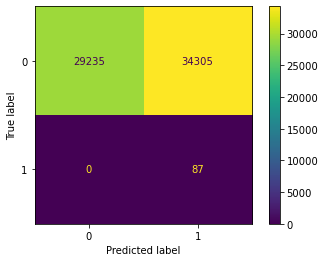

In [5]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(fmodel_tomek, test, test_y)

#### TOMEK + RUS MODEL

In [7]:
test_pred2 = fmodel_rus.predict(test)

recall_test2 = round(recall_score(test_y,test_pred2),3)
f1_test2 = round(f1_score(y_true=test_y,y_pred=test_pred2),3)
bacc_test2 = round(balanced_accuracy_score(test_y,y_pred=test_pred2),3)

print("Recall of Final Tomek+RUS Model: {}".format(recall_test2))
print("F1 Score of Final Tomek+RUS Model: {}".format(f1_test2))
print('Balanced Accuracy Score of Final Tomek+RUS Model: {}'.format(bacc_test2))

Recall of Final Tomek+RUS Model: 1.0
F1 Score of Final Tomek+RUS Model: 0.003
Balanced Accuracy Score of Final Tomek+RUS Model: 0.5


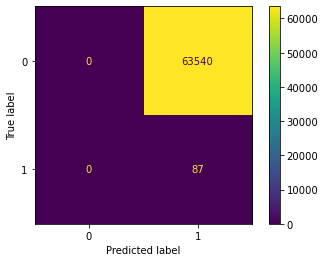

In [7]:
#Confusion Matrix
ConfusionMatrixDisplay.from_estimator(fmodel_rus, test, test_y)

Need to check the correlations between the columns in the data with each other as that can play a part in interpreting visualizations that will help us breakdown what the models are doing. We will look at the training data for these correlation matrices.

In [8]:
#TOMEK DATA

#tomek_X_train.ClientOrig.value_counts() 
#Looks like they all start with a 'C' in clientOrig for the training data, 
#which is why we get all NaN's in the correlation matrix

#new_tXt = tomek_X_train.drop('ClientOrig',axis=1,inplace=False)
#new_tXt.corr().style.background_gradient(cmap='coolwarm')

#I tried to remove ClientOrig from tomek_X_train because the colors in the matrix were acting
#weird for columns after that column - I thought it was the cause of the weird behavior, but
#even when its removed, it still acts weird.

#If you want to see the plot in Jupyter, run this piece of code
#tomek_X_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
dfi.export(tomek_X_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2),'TomekTrainingCorrelation.png')

NameError: name 'tomek_X_train' is not defined

In [ ]:
#RUS + TOMEK DATA
dfi.export(rus_X_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2), 'RUS+TomekTrainingCorrelation.png')

## Model Visualization 

### Tomek Data - Gaussian Naive Bayes Model 

In [15]:
#explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
#shap_values = explainer.shap_values(X_test, nsamples=100)

shap_data = shap.sample(tomek_X_train,nsamples=400) #This just samples data from the original dataset

explainer = shap.KernelExplainer(fmodel_tomek.predict_proba,shap_data)
shap_values_tomek = explainer.shap_values(test,nsamples=100)

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/63627 [00:00<?, ?it/s]

In [33]:
#Force Plot
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test.iloc[0,:])

In [16]:
#Save the shap_values_tomek
pickle_list = [shap_values_tomek] 
f = open('TomekShapValues.pckl','wb')
pickle.dump(pickle_list,f)
f.close()

In [11]:
#Re-import the shap_values_tomek
f = open('TomekShapValues.pckl','rb')
pickle_list1 = pickle.load(f)
f.close()

shap_values_tomek = pickle_list1[0]

In [19]:
abs_mean_shap = np.mean(np.array([np.absolute(np.array(shap_values_tomek[0])), np.absolute(np.array(shap_values_tomek[1]))]), axis=0)


In [22]:
# Get a dataframe of the shap values for each feature, for each sample
# Then, create an average per feature
shap_df = pd.DataFrame(data=abs_mean_shap, columns=test.columns)
shap_avg_df = pd.DataFrame(shap_df.mean().to_dict(),index=[shap_df.index.values[-1]])

# Reformat the dataframe
shap_plot_df = shap_avg_df.T.reset_index()
shap_plot_df.columns = ['Feature', 'Mean ABS SHAP']

In [31]:
shap_plot_df.sort_values(by='Mean ABS SHAP',axis=0,ascending=False)

,Feature,Mean ABS SHAP
7,ClientDest,0.187016
2,x0_PAYMENT,0.186891
10,newbalanceOrig_4root,0.125225
1,x0_DEBIT,0.008162
9,oldbalanceOrig_4root,0.006166
11,oldbalanceDest_4root,0.004575
3,x0_TRANSFER,0.003672
8,amount_4root,0.003637
0,x0_CASH_OUT,0.002629
12,newbalanceDest_4root,0.001650


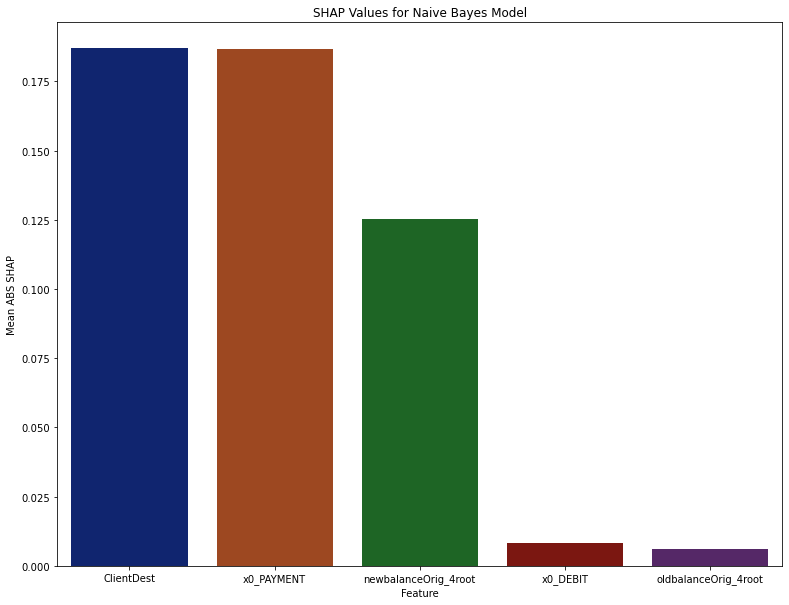

In [38]:
# Create a top 5 plot
plt.figure(figsize=(13, 10))
sns.barplot(data=shap_plot_df.sort_values(by='Mean ABS SHAP', ascending=False).head(n=5), x='Feature', y='Mean ABS SHAP', palette="dark").set(title="SHAP Values for Naive Bayes Model")
plt.show()

### RUS + Tomek - Random Forest Classifier 

I will look at the feature importance values inherent in the sklearn Random Forest Classifier. I will also check out SHAP values for tree algorithms to see how they work.

In [9]:
explainer = shap.TreeExplainer(fmodel_rus)
shap_values_rus = explainer.shap_values(test)

In [12]:
abs_mean_shap2 = np.mean(np.array([np.absolute(np.array(shap_values_rus[0])), np.absolute(np.array(shap_values_rus[1]))]), axis=0)


In [15]:
#Get a dataframe of the shap values for each feature, for each sample
#Then, create an average per feature
shap_df2 = pd.DataFrame(data=abs_mean_shap2, columns=test.columns)
shap_avg_df2 = pd.DataFrame(shap_df2.mean().to_dict(),index=[shap_df2.index.values[-1]])

# Reformat the dataframe
shap_plot_df2 = shap_avg_df2.T.reset_index()
shap_plot_df2.columns = ['Feature', 'Mean ABS SHAP']

In [17]:
shap_plot_df2

,Feature,Mean ABS SHAP
0,x0_CASH_OUT,0.0
1,x0_DEBIT,0.0
2,x0_PAYMENT,0.0
3,x0_TRANSFER,0.0
4,NO_ID_unique,0.0
5,ND_ID_unique,0.0
6,ClientOrig,0.0
7,ClientDest,0.0
8,amount_4root,0.0
9,oldbalanceOrig_4root,0.0


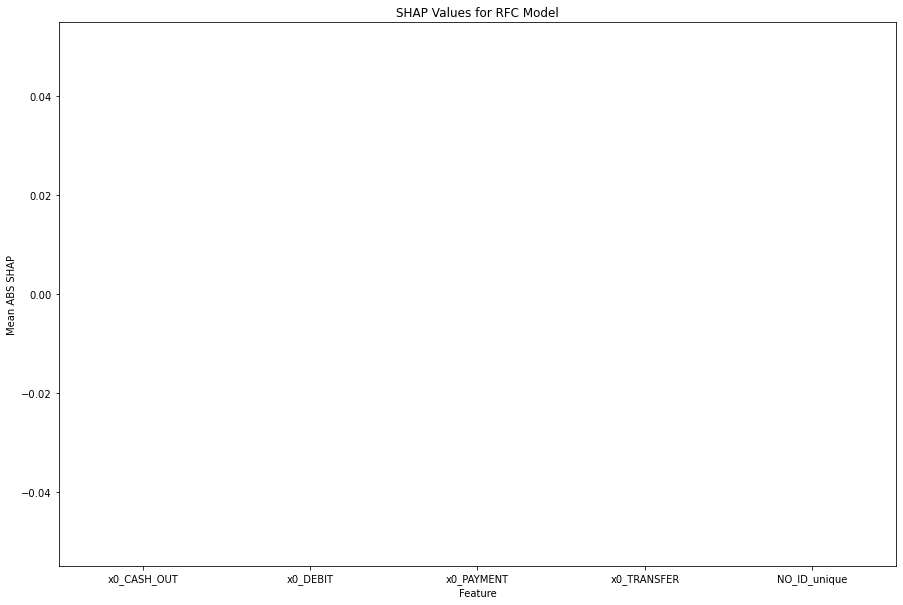

In [39]:
# Create a top 5 plot
plt.figure(figsize=(15, 10))
sns.barplot(data=shap_plot_df2.sort_values(by='Mean ABS SHAP', ascending=False).head(n=5), x='Feature', y='Mean ABS SHAP', palette="dark").set(title="SHAP Values for RFC Model")
plt.show()